1. Data Collection 

In [1]:
# Data collection
import os
path = r'C:\Users\Dharun G V\.cache\kagglehub\datasets\drblack00\isl-csltr-indian-sign-language-dataset\versions\1\ISL_CSLRT_Corpus\ISL_CSLRT_Corpus'
os.listdir(path)

['corpus_csv_files',
 'Frames_Sentence_Level',
 'Frames_Word_Level',
 'ISL_CSLRT.txt',
 'Videos_Sentence_Level']

2. Features Extraction

In [4]:
import os
import cv2
import numpy as np
import mediapipe as mp
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Paths
dataset_path = path  # <-- Change this!
image_size = (224, 224)

# MediaPipe setup
mp_hands = mp.solutions.hands
mp_face = mp.solutions.face_mesh
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)
face_mesh = mp_face.FaceMesh(static_image_mode=True, max_num_faces=1)

X = []
Y = []

def extract_features(image):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Hands
    hand_results = hands.process(rgb_image)
    hand_features = []
    if hand_results.multi_hand_landmarks:
        for hand_landmarks in hand_results.multi_hand_landmarks[:2]:
            for lm in hand_landmarks.landmark:
                hand_features.extend([lm.x, lm.y, lm.z])
        if len(hand_results.multi_hand_landmarks) == 1:
            hand_features.extend([0] * 21 * 3)  # pad for second hand
    else:
        hand_features.extend([0] * 21 * 3 * 2)  # pad both hands

    # Face
    face_results = face_mesh.process(rgb_image)
    face_features = []
    if face_results.multi_face_landmarks:
        for lm in face_results.multi_face_landmarks[0].landmark:
            face_features.extend([lm.x, lm.y, lm.z])
    else:
        face_features.extend([0] * 468 * 3)  # pad no face

    return np.array(hand_features + face_features, dtype=np.float32)

# Walk dataset
image_paths = []
labels = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))
        elif file.lower().endswith(('.mp4', '.avi', '.mov')):
            video_path = os.path.join(root, file)
            cap = cv2.VideoCapture(video_path)
            success, frame = cap.read()
            frame_number = 0
            while success:
                image_paths.append((video_path, frame_number))
                labels.append(os.path.basename(root))
                frame_number += 1
                success, frame = cap.read()
            cap.release()

# Process data
for item, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc="Processing ISL-CSLTR"):
    if isinstance(item, tuple):
        video_path, frame_number = item
        cap = cv2.VideoCapture(video_path)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        success, frame = cap.read()
        cap.release()
        if not success or frame is None or frame.size == 0:
            continue
        image = frame
    else:
        image = cv2.imread(item)
        if image is None or image.size == 0:
            continue

    features = extract_features(image)
    X.append(features)
    Y.append(label)

# Convert to numpy arrays
X = np.array(X, dtype=np.float32)
label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)

# Normalize
if X.size > 0:
    X = (X - X.min()) / (X.max() - X.min())

# Save to disk
np.save('X1.npy', X)
np.save('Y1.npy', Y_encoded)
np.save('label_classes1.npy', label_encoder.classes_)

print(f"Data saved! Total samples: {len(X)}")


Processing ISL-CSLTR: 100%|██████████| 88929/88929 [4:25:58<00:00,  5.57it/s]   


Data saved! Total samples: 88929


In [5]:
x = np.load('X1.npy')
y = np.load('Y1.npy')
l = np.load('label_classes1.npy')
print('X: ',x, 'Size: ', len(x))
print('Y: ',y, 'Size: ', len(y))
print('Label: ',l, 'No. of Classes: ', len(l))

X:  [[0.42087683 0.5747858  0.17450848 ... 0.56609774 0.35828546 0.16741355]
 [0.42074627 0.5747858  0.17450848 ... 0.56601226 0.35839972 0.16720879]
 [0.42068875 0.5748967  0.17450848 ... 0.56628466 0.3583377  0.16736114]
 ...
 [0.64961576 0.65510654 0.17450866 ... 0.28581816 0.50219136 0.18419059]
 [0.6733965  0.49065554 0.17450891 ... 0.28603166 0.502064   0.18373904]
 [0.6733297  0.49076974 0.17450891 ... 0.28590387 0.5020179  0.18382883]] Size:  88929
Y:  [  0   0   0 ... 221 221 221] Size:  88929
Label:  ['1' '2' '3' '4' '5' '6' '7' 'A LOT' 'ABUSE' 'AFRAID' 'AGREE' 'ALL'
 'ANGRY' 'ANYTHING' 'APPRECIATE' 'BAD' 'BEAUTIFUL' 'BECOME' 'BED' 'BORED'
 'BRING' 'CHAT' 'CLASS' 'COLD' 'COLLEGE_SCHOOL' 'COMB' 'COME'
 'CONGRATULATIONS' 'CRYING' 'DARE' 'DIFFERENCE' 'DILEMMA' 'DISAPPOINTED'
 'DO' "DON'T CARE" 'ENJOY' 'FAVOUR' 'FEVER' 'FINE' 'FOOD' 'FREE' 'FRIEND'
 'FROM' 'GO' 'GOOD' 'GRATEFUL' 'HAD' 'HAPPENED' 'HAPPY' 'HEAR' 'HEART'
 'HELLO_HI' 'HELP' 'HIDING' 'HOW' 'HUNGRY' 'HURT'
 'He is goin

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, TimeDistributed, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

# Model parameters
timesteps = 30  # Number of consecutive frames per sample
n_features = 126  # From your feature extraction (21*3*2 hands + 468*3 face)
num_classes = len(np.load("label_classes1.npy"))
model = Sequential([
    # Temporal CNN Block
    Conv1D(filters=128, kernel_size=5, activation='relu', 
          input_shape=(timesteps, n_features)),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),
    
    # LSTM Sequence Processing
    LSTM(256, return_sequences=True),
    LSTM(128),
    
    # Classification Head
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam', 
             metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 26, 128)           80768     
                                                                 
 max_pooling1d (MaxPooling1  (None, 13, 128)           0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 128)           0         
                                                                 
 lstm (LSTM)                 (None, 13, 256)           394240    
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                        

In [4]:
def create_sequences(X, Y, seq_length):
    X_seq, Y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        Y_seq.append(Y[i+seq_length])
    return np.array(X_seq), np.array(Y_seq)

# After loading X and Y from your code
X = np.load("X1.npy")
Y_encoded = np.load("Y1.npy")
X_sequences, Y_sequences = create_sequences(X, Y_encoded, timesteps)

#Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(
    X_sequences, Y_sequences, test_size=0.2, random_state=42
)


MemoryError: Unable to allocate 12.2 GiB for an array with shape (71119, 30, 1530) and data type float32

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
855/855 [==============================] - 34s 37ms/step - loss: 2.8628 - accuracy: 0.1091 - val_loss: 2.0077 - val_accuracy: 0.2512
Epoch 2/100
855/855 [==============================] - 30s 35ms/step - loss: 1.7601 - accuracy: 0.3455 - val_loss: 1.0406 - val_accuracy: 0.6086
Epoch 3/100
855/855 [==============================] - 30s 35ms/step - loss: 1.1016 - accuracy: 0.6008 - val_loss: 0.6672 - val_accuracy: 0.7571
Epoch 4/100
855/855 [==============================] - 30s 35ms/step - loss: 0.7152 - accuracy: 0.7545 - val_loss: 0.2833 - val_accuracy: 0.9099
Epoch 5/100
855/855 [==============================] - 29s 34ms/step - loss: 0.4768 - accuracy: 0.8493 - val_loss: 0.2123 - val_accuracy: 0.9494
Epoch 6/100
855/855 [==============================] - 31s 36ms/step - loss: 0.3294 - accuracy: 0.9036 - val_loss: 0.1633 - val_accuracy: 0.9532
Epoch 7/100
855/855 [==============================] - 30s 35ms/step - loss: 0.2521 - accuracy: 0.9348 - val_loss: 0.0694 - val_ac

In [20]:
#Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print(f'Test Loss: {loss * 100: .2f}%')
print(f'Test Accuracy: {accuracy * 100: .2f}%')

267/267 [==============================] - 3s 11ms/step - loss: 0.0117 - accuracy: 0.9971
Test Loss:  1.17%
Test Accuracy:  99.71%


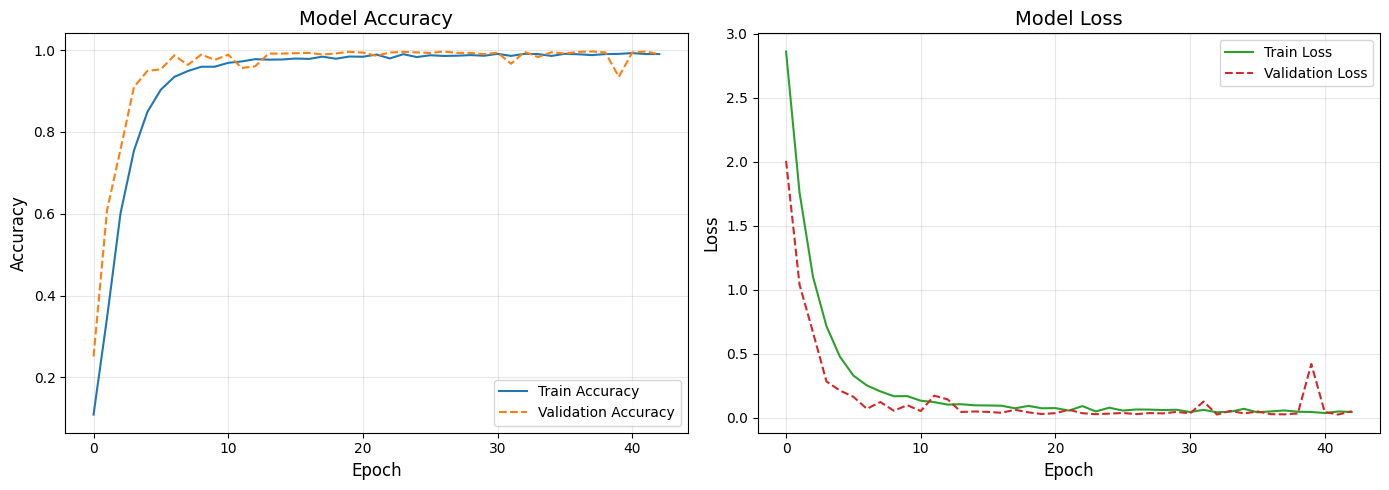

In [26]:
# Plotting accuracy and loss graph
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

def plot_training_history(history):
    """Visualize model training progress using accuracy and loss metrics"""
    
    # Create figure with two subplots
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color='#1f77b4')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], 
                label='Validation Accuracy', 
                color='#ff7f0e', 
                linestyle='--')
    plt.title('Model Accuracy', fontsize=14)
    plt.ylabel('Accuracy', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', color='#2ca02c')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], 
                label='Validation Loss', 
                color='#d62728', 
                linestyle='--')
    plt.title('Model Loss', fontsize=14)
    plt.ylabel('Loss', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
plot_training_history(history)

In [23]:
# Save model
model.save("slr_test2_model.h5")

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
model = load_model('slr_test2_model.h5')

# Load data
X = np.load('X1.npy')
Y = np.load('Y1.npy')
label_classes = np.load('label_classes1.npy')

# One-hot encode labels
num_classes = len(np.unique(Y))
Y = to_categorical(Y, num_classes)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# Predict on test set
Y_pred_probs = model.predict(X_test)
Y_pred = np.argmax(Y_pred_probs, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Accuracy
accuracy = accuracy_score(Y_true, Y_pred)

# Precision, Recall, F1 (macro average for multiclass)
precision = precision_score(Y_true, Y_pred, average='macro')
recall = recall_score(Y_true, Y_pred, average='macro')
f1 = f1_score(Y_true, Y_pred, average='macro')

print(f"Accuracy:  {accuracy * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"Recall:    {recall * 100:.4f}")
print(f"F1 Score:  {f1 * 100:.4f}")

# Optional: Detailed classification report
print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred, target_names=label_classes))


ValueError: in user code:

    File "c:\Users\Dharun G V\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Dharun G V\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Dharun G V\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Dharun G V\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 2357, in predict_step
        return self(x, training=False)
    File "c:\Users\Dharun G V\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Dharun G V\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_4" is incompatible with the layer: expected shape=(None, 30, 126), found shape=(None, 1530)


In [27]:
# Predict and generate classification report
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print(classification_report(y_test, y_pred))

267/267 [==============================] - 3s 11ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       250
           1       1.00      0.98      0.99       262
           2       0.97      1.00      0.98       243
           3       0.99      0.99      0.99       246
           4       1.00      0.99      0.99       234
           5       1.00      1.00      1.00       249
           6       1.00      1.00      1.00       256
           7       1.00      1.00      1.00       240
           8       1.00      1.00      1.00       227
           9       1.00      1.00      1.00       221
          10       1.00      1.00      1.00       273
          11       1.00      0.99      1.00       271
          12       1.00      1.00      1.00       221
          13       1.00      1.00      1.00       244
          14       0.99      1.00      0.99       217
          15       1.00      0.99      0.99       239
          16       1.00  

In [35]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

model = load_model("slr_test2_model.h5")

# Load 
label_classes = np.load("label_classes1.npy", allow_pickle=True)
label_encoder = LabelEncoder()
label_encoder.classes_ = label_classes 

# Predict class probabilities
y_pred_probs = model.predict(x_test)
# Convert probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# Decode labels to class names
actual_labels = label_encoder.inverse_transform(y_test)
predicted_labels = label_encoder.inverse_transform(y_pred)

# Display a table of actual vs predicted labels (first 20 samples for brevity)
print(f"{'Sample':<6} {'Actual':<20} {'Predicted':<20}")
print('-'*50)
for i in range(20):
    print(f"{i:<6} {actual_labels[i]:<20} {predicted_labels[i]:<20}")

# Optionally, show mismatches only
print("\nMismatches:")
for i, (act, pred) in enumerate(zip(actual_labels, predicted_labels)):
    if act != pred:
        print(f"Sample {i}: Actual = {act}, Predicted = {pred}")


267/267 [==============================] - 4s 14ms/step
Sample Actual               Predicted           
--------------------------------------------------
0      A LOT                A LOT               
1      ALL                  ALL                 
2      BRING                BRING               
3      DARE                 DARE                
4      AGREE                AGREE               
5      DISAPPOINTED         DISAPPOINTED        
6      AGREE                AGREE               
7      COME                 COME                
8      COMB                 COMB                
9      ALL                  ALL                 
10     2                    2                   
11     CHAT                 CHAT                
12     AFRAID               AFRAID              
13     DISAPPOINTED         DISAPPOINTED        
14     ANGRY                ANGRY               
15     ABUSE                ABUSE               
16     5                    5                   
17     CLAS

In [1]:
import cv2
import numpy as np
import mediapipe as mp
from collections import deque
from tensorflow.keras.models import load_model
import pyttsx3  # For speech
import time

# Load model and labels
model = load_model('slr_test2_model.h5')
label_classes = np.load('label_classes1.npy')

# MediaPipe setup
mp_hands = mp.solutions.hands
mp_face = mp.solutions.face_mesh
mp_drawing = mp.solutions.drawing_utils

hands = mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5, min_tracking_confidence=0.5)
face_mesh = mp_face.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# For speech
engine = pyttsx3.init()
last_prediction = ""
last_speech_time = 0

# Sequence buffer
SEQ_LEN = 30
FEATURES = 126  # Adjust if your feature vector is different
sequence = deque(maxlen=SEQ_LEN)

def extract_landmarks(image):
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results_hands = hands.process(image_rgb)

    # Hand landmarks
    hand_landmarks = []
    if results_hands.multi_hand_landmarks:
        for hand in results_hands.multi_hand_landmarks[:2]:
            for lm in hand.landmark:
                hand_landmarks.extend([lm.x, lm.y, lm.z])
        if len(results_hands.multi_hand_landmarks) == 1:
            hand_landmarks.extend([0] * 21 * 3)
    else:
        hand_landmarks.extend([0] * 21 * 3 * 2)

    # Final features: only hand landmarks
    features = hand_landmarks

    # Ensure it’s exactly 126
    if len(features) < 126:
        features.extend([0] * (126 - len(features)))
    return np.array(features, dtype=np.float32)


    # Face landmarks (use only first 16 or 21 for speed, or all 468 if needed)
    face_landmarks = []
    if results_face.multi_face_landmarks:
        # Use first N landmarks for speed (e.g., 16 for mouth, eyes, etc.)
        for idx, lm in enumerate(results_face.multi_face_landmarks[0].landmark):
            if idx >= 16:  # Change to 468 if you want all
                break
            face_landmarks.extend([lm.x, lm.y, lm.z])
    else:
        face_landmarks.extend([0] * 16 * 3)

    # Combine
    features = hand_landmarks + face_landmarks
    # Pad if less than expected
    if len(features) < FEATURES:
        features.extend([0] * (FEATURES - len(features)))
    return np.array(features, dtype=np.float32)

# OpenCV video capture
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Flip for natural interaction
    frame = cv2.flip(frame, 1)

    # Extract features
    features = extract_landmarks(frame)
    sequence.append(features)

    # Draw hand and face landmarks
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    hand_results = hands.process(image_rgb)
    face_results = face_mesh.process(image_rgb)

    if hand_results.multi_hand_landmarks:
        for hand_landmarks in hand_results.multi_hand_landmarks:
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
    if face_results.multi_face_landmarks:
        for face_landmarks in face_results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                frame, face_landmarks, mp_face.FACEMESH_CONTOURS,
                landmark_drawing_spec=mp_drawing.DrawingSpec(color=(0,255,0), thickness=1, circle_radius=1),
                connection_drawing_spec=mp_drawing.DrawingSpec(color=(0,0,255), thickness=1)
            )

    # If enough frames, predict
    if len(sequence) == SEQ_LEN:
        input_data = np.expand_dims(np.array(sequence), axis=0)  # (1, 30, 126)
        prediction = model.predict(input_data)
        pred_class = np.argmax(prediction)
        pred_label = label_classes[pred_class]

        # Display prediction
        cv2.putText(frame, f'Prediction: {pred_label}', (10, 40),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Speech (every 2 seconds or if prediction changes)
        current_time = time.time()
        if pred_label != last_prediction or (current_time - last_speech_time) > 2:
            engine.say(pred_label)
            engine.runAndWait()
            last_prediction = pred_label
            last_speech_time = current_time

    cv2.imshow("Sign Language Recognition", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 30ms/step


In [2]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Load features and labels
X = np.load('X1.npy')  # shape: (samples, 1530)
Y = np.load('Y1.npy')
label_classes = np.load('label_classes1.npy')
num_classes = len(label_classes)

# One-hot encode labels
Y_cat = to_categorical(Y, num_classes)

# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y_cat, test_size=0.2, random_state=42, stratify=Y)


In [3]:
X_train = X_train.reshape(-1, 1, 1530)
X_test = X_test.reshape(-1, 1, 1530)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Activation, Dropout, LSTM, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential([
    Input(shape=(1, 1530)),
    Conv1D(128, kernel_size=1, padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.3),
    LSTM(128, return_sequences=False),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 128)            195968    
                                                                 
 batch_normalization (Batch  (None, 1, 128)            512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 1, 128)            0         
                                                                 
 dropout (Dropout)           (None, 1, 128)            0         
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                        

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
model = load_model('word_model.h5')

checkpoint = ModelCheckpoint(
    'word_model.h5',
    moniter='val_loss',
    save_freq='epoch',
    period=10,
    save_weights_only=False,
    verbose=1 
)
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, Y_test),
    callbacks=[checkpoint]
)


Epoch 1/100
2224/2224 [==============================] - 11s 5ms/step - loss: 2.8643 - accuracy: 0.3006 - val_loss: 2.7461 - val_accuracy: 0.3352
Epoch 2/100
2224/2224 [==============================] - 9s 4ms/step - loss: 2.8620 - accuracy: 0.3000 - val_loss: 2.7475 - val_accuracy: 0.3385
Epoch 3/100
2224/2224 [==============================] - 9s 4ms/step - loss: 2.8586 - accuracy: 0.3007 - val_loss: 2.7167 - val_accuracy: 0.3431
Epoch 4/100
2224/2224 [==============================] - 10s 4ms/step - loss: 2.8536 - accuracy: 0.3021 - val_loss: 2.7743 - val_accuracy: 0.3328
Epoch 5/100
2224/2224 [==============================] - 10s 4ms/step - loss: 2.8678 - accuracy: 0.2995 - val_loss: 2.7432 - val_accuracy: 0.3392
Epoch 6/100
2224/2224 [==============================] - 9s 4ms/step - loss: 2.8635 - accuracy: 0.3012 - val_loss: 2.7310 - val_accuracy: 0.3382
Epoch 7/100
2224/2224 [==============================] - 10s 4ms/step - loss: 2.8661 - accuracy: 0.2997 - val_loss: 2.6992 - va

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from tensorflow.keras.models import load_model
model = load_model('word_model.h5')
# Predict on test set
Y_pred_probs = model.predict(X_test)
Y_pred = np.argmax(Y_pred_probs, axis=1)
Y_true = np.argmax(Y_test, axis=1)

# Accuracy
accuracy = accuracy_score(Y_true, Y_pred)

# Precision, Recall, F1 (macro average for multiclass)
precision = precision_score(Y_true, Y_pred, average='macro')
recall = recall_score(Y_true, Y_pred, average='macro')
f1 = f1_score(Y_true, Y_pred, average='macro')

print(f"Accuracy:  {accuracy * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"Recall:    {recall * 100:.4f}")
print(f"F1 Score:  {f1 * 100:.4f}")

# Optional: Detailed classification report
#print("\nClassification Report:\n")
#print(classification_report(Y_true, Y_pred, target_names=label_classes))

556/556 [==============================] - 1s 1ms/step
Accuracy:  33.1272
Precision: 25.2413
Recall:    11.9105
F1 Score:  14.5499


c:\Users\Dharun G V\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Save model
model.save('word_model.h5')